In [2]:
#if (!require("BiocManager", quietly = TRUE))
  #install.packages("BiocManager")
#BiocManager::install("DOSE")
library(clusterProfiler)
library(tidyverse)
library(forcats)
library(ggrepel)
library(enrichplot)
library(tibble)
library(ggupset)
library(ggridges)
library(gage)
library(DOSE)
library(pathview)
library(ggpubr)



clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks clusterProfiler::filter(), stats::filter()
✖ dplyr::lag()  

# Generate ranked list of ko_id's and LFC
numeric vector: fold change or other type of numerical variable
- here I sorted by differential expression, taking the sign from LFC and value of significance from adjusted pvalue.
- top: most upregulated genes
- middle: most insignificantly expressed genes
- bottom: most downregulated genes

named vector: every number has a name, the corresponding gene ID
sorted vector: number should be sorted in decreasing order
import your data from a csv file, the file should contains two columns, one for gene ID (no duplicated ID allowed) and another one for fold change.
### Over expression analysis uses only DE genes
### Gene set expression analysis uses all genes with DE values

In [23]:
read.data = function(df){
    df = read.csv(paste("./de_res_files/",df,".csv",sep=''))
    colnames(df)[1] = 'ko_id'
    df = filter(df, padj<=0.05)
    # create a ranked gene list
    genes=df$log2FoldChange
    names(genes)=as.character(df$ko_id)
    geneList=sort(genes, decreasing=T)
    # geneList is a sorted list of genes with thier DE ranking and ko_id as list names
    print(max(geneList))
    geneList
    }

                       

In [24]:
#High vs Low Fe
HvL8.geneList = read.data('lfc8.k.HvL')
HvL6.geneList = read.data('lfc6.k.HvL')
HvL13.geneList = read.data('lfc13.k.HvL')
#Fe ammendment vs Low Fe
AvL4.geneList = read.data('lfc4.k.AvL')
AvL8.geneList = read.data('lfc8.k.AvL')
AvL6.geneList = read.data('lfc6.k.AvL')
AvL13.geneList = read.data('lfc13.k.AvL')
#Fe ammendment vs High Fe
AvH8.geneList = read.data('lfc8.k.AvH')
AvH6.geneList = read.data('lfc6.k.AvH')
AvH13.geneList = read.data('lfc13.k.AvH')
tail(AvH13.geneList)

[1] 3.07505
[1] 1.822534
[1] 4.022455
[1] 2.096725
[1] 4.830949
[1] 2.066053
[1] 3.833375
[1] 6.583761
[1] 5.234368
[1] 2.806929


K14291    K22156    K18710    K10808    K10734    K00525 
-3.078023 -3.085140 -3.160268 -3.196746 -3.212495 -3.904022

# Module enrichment bar charts from a paper

In [6]:

mEnrich=function(df, uni, uTreat, dTreat, org){
    
    df$ko_id = df$row
    ## create a universe which has all ko's from the comparison
    uni = unique(uni$ko_id)
    #pull out significantly difference up regulated genes (high iron treatment)
    up = subset(df, log2FoldChange > 0 & padj < 0.01)
    #pull out significantly differentially down regulated genes (low iron treatment)
    down = subset(df, log2FoldChange < 0 & padj < 0.01)
    print(dim(up))
    print(dim(down))
    up_out = enrichMKEGG(up$ko_id, pvalueCutoff = 0.05, organism='ko', pAdjustMethod = 'fdr', keyType='kegg', universe=uni)
    up_res = up_out@result
    fin_up = filter(up_res, p.adjust<0.05)
    fin_up = fin_up %>% mutate(Treatment = uTreat)
    
    down_out = enrichMKEGG(down$ko_id, pvalueCutoff = 0.05, organism='ko', pAdjustMethod = 'fdr', keyType='kegg', universe=uni)
    down_res = down_out@result
    fin_down = filter(down_res, p.adjust<0.05)
    fin_down = fin_down %>% mutate(Treatment=dTreat)
    
    enrich_full = rbind(fin_up, fin_down)
    
   p= ggplot(enrich_full, aes(Count, reorder(Description,-Count), fill=Treatment)) +
    geom_bar(stat='identity', width=0.9,position=position_dodge(), color='black')+
    theme_classic(base_size=15)+ ylab('KEGG Module') +
    ggtitle(paste(org, " enrichment between\n",uTreat," and ", dTreat, sep='')) +
    geom_vline(xintercept = 0, linetype='dashed') +
    scale_fill_manual(values=c('black','white'), breaks=c(uTreat, dTreat)) +
    scale_y_discrete(labels=function(x) str_wrap(x,15))+
    xlab('Number of Hits to KEGG Module') 
                     p
}



[1] 43  8
[1] 104   8


Reading KEGG annotation online: "https://rest.kegg.jp/link/ko/module"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/module"...



[1] 203   8
[1] 405   8


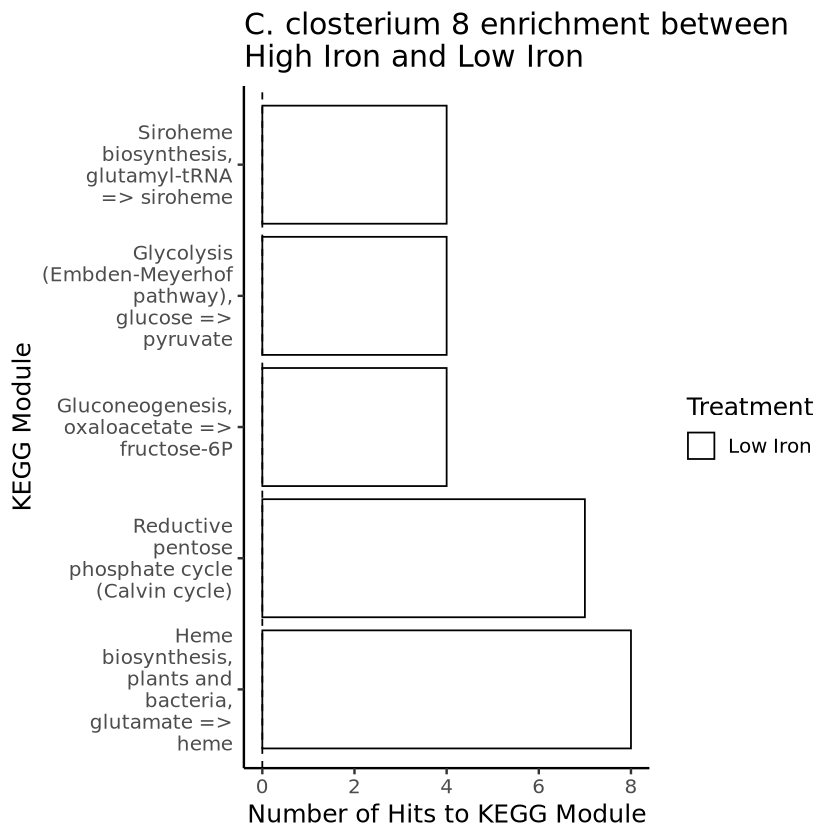

[1] 203   8
[1] 405   8


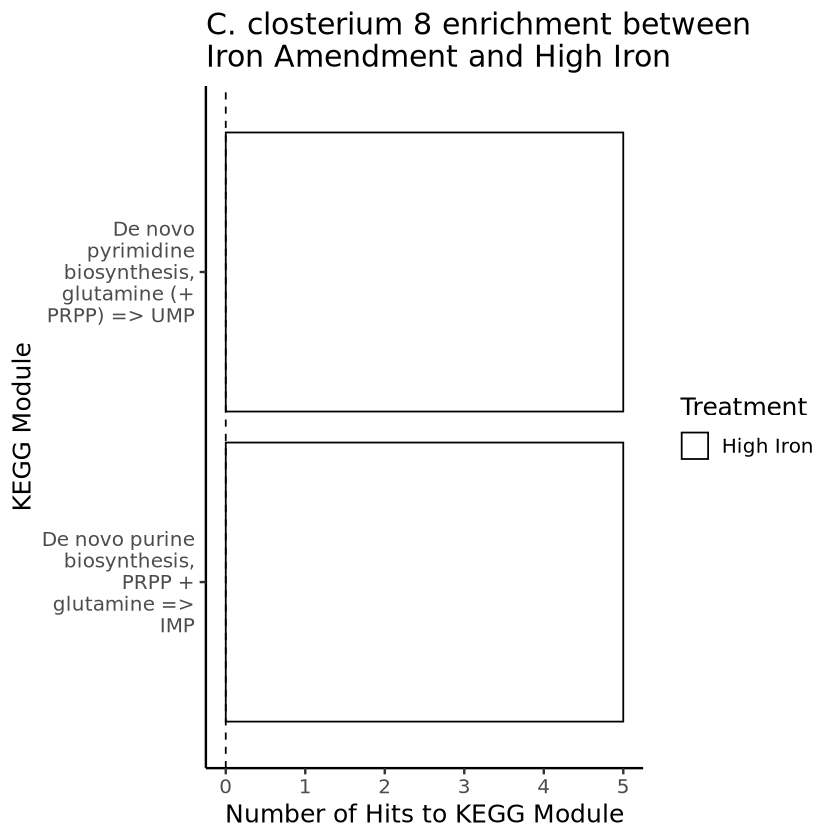

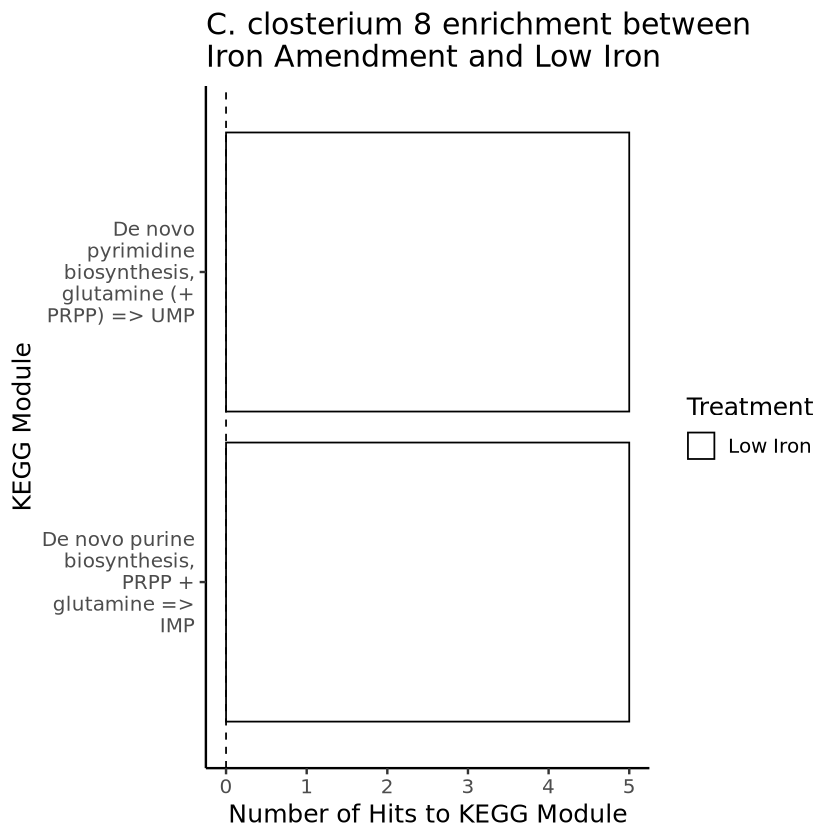

In [7]:
hvl8_de = read.csv('./de_res_files/HvL8.k.csv')
avh8_de = read.csv('./de_res_files/AvH8.k.csv')
avl8_de = read.csv('./de_res_files/AvL8.k.csv')
uni8 = read.csv('../kegg_names/ko8_ls.csv')

mEnrich(hvl8_de, uni8, 'High Iron', 'Low Iron', 'C. closterium 8')
mEnrich(avl8_de, uni8, 'Iron Amendment', 'High Iron', 'C. closterium 8')
mEnrich(avl8_de, uni8, 'Iron Amendment', 'Low Iron', 'C. closterium 8')

[1] 599   8
[1] 323   8
[1] 580   8
[1] 275   8


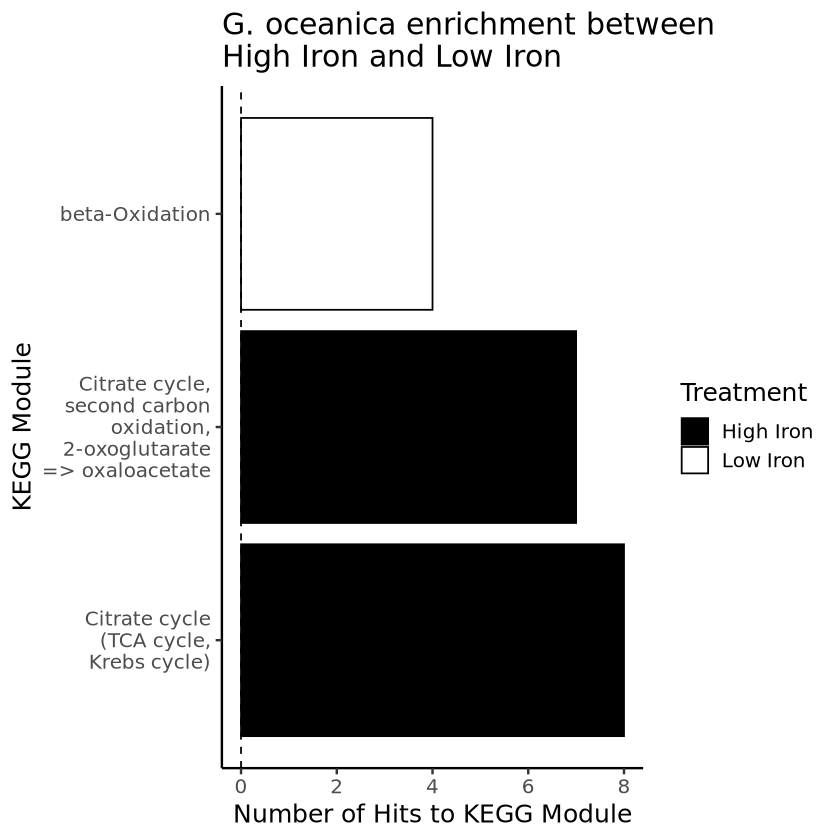

[1] 580   8
[1] 275   8


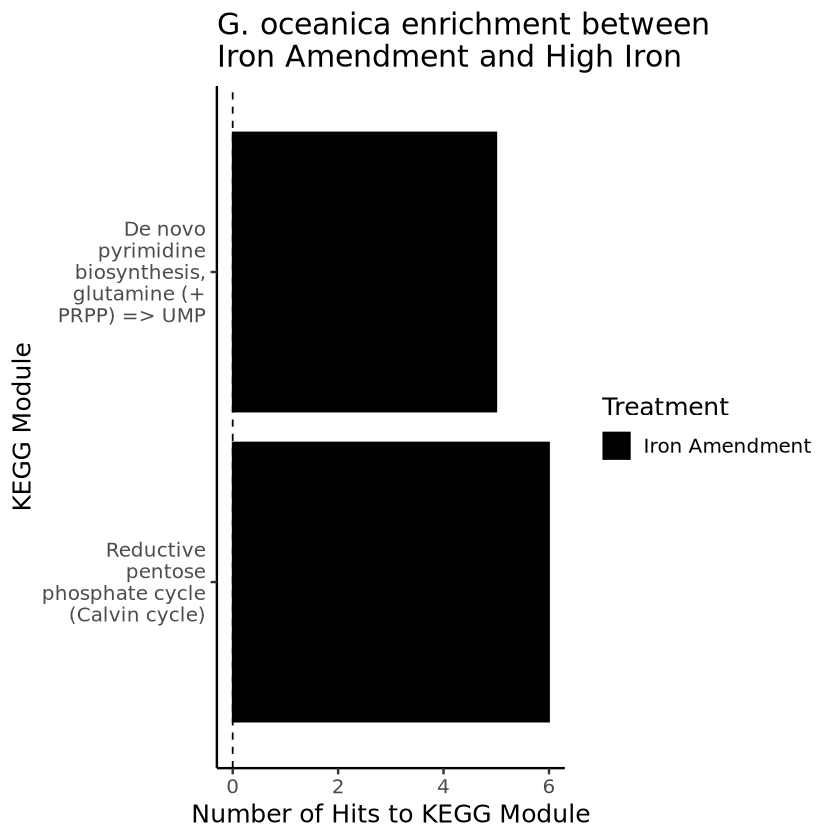

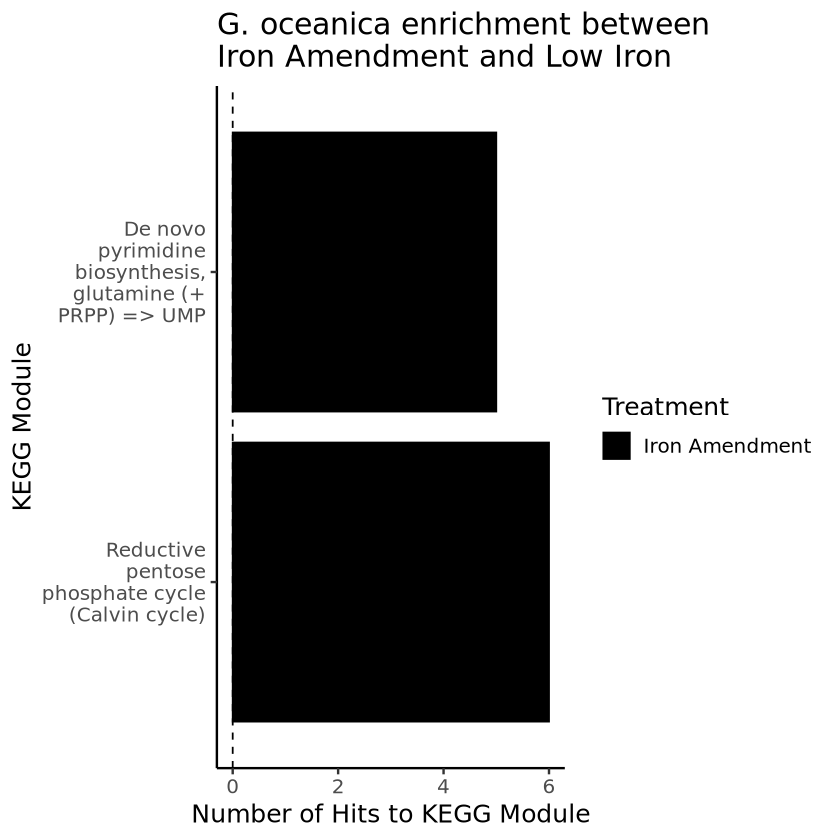

In [10]:
hvl6_de = read.csv('./de_res_files/HvL6.k.csv')
avh6_de = read.csv('./de_res_files/AvH6.k.csv')
avl6_de = read.csv('./de_res_files/AvL6.k.csv')
uni6 = read.csv('../kegg_names/ko6_ls.csv')

mEnrich(hvl6_de, uni6, 'High Iron', 'Low Iron', 'G. oceanica')
mEnrich(avl6_de, uni6, 'Iron Amendment', 'High Iron', 'G. oceanica')
mEnrich(avl6_de, uni6, 'Iron Amendment', 'Low Iron', 'G. oceanica')

[1] 470   8
[1] 299   8


Warning message in rep(yes, length.out = len):
“'x' is NULL so the result will be NULL”
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr

[1] 470   8
[1] 394   8
[1] 470   8
[1] 394   8


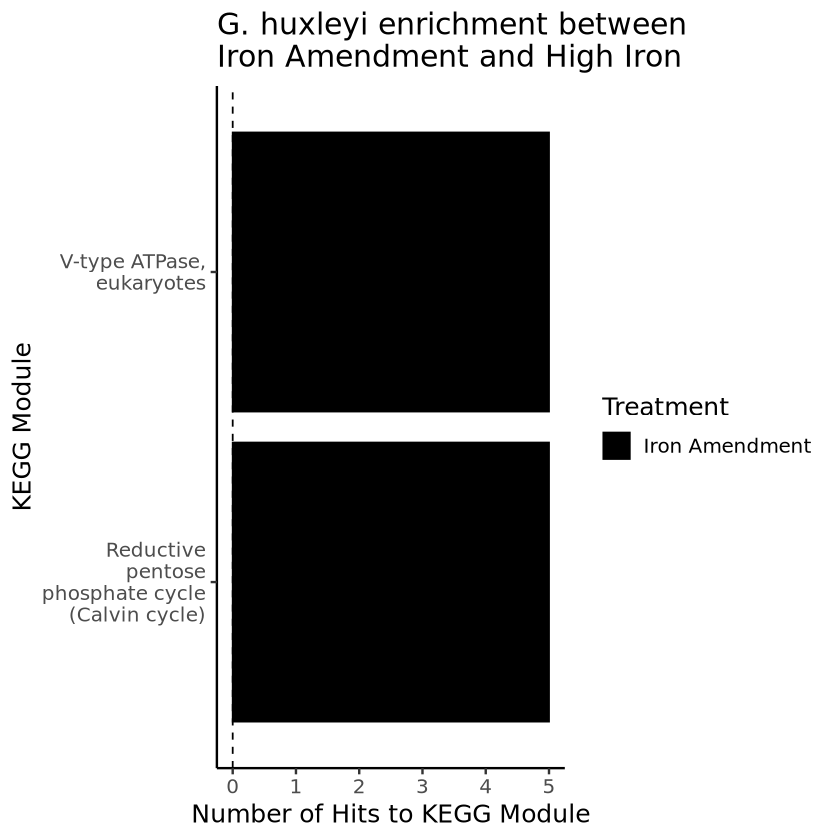

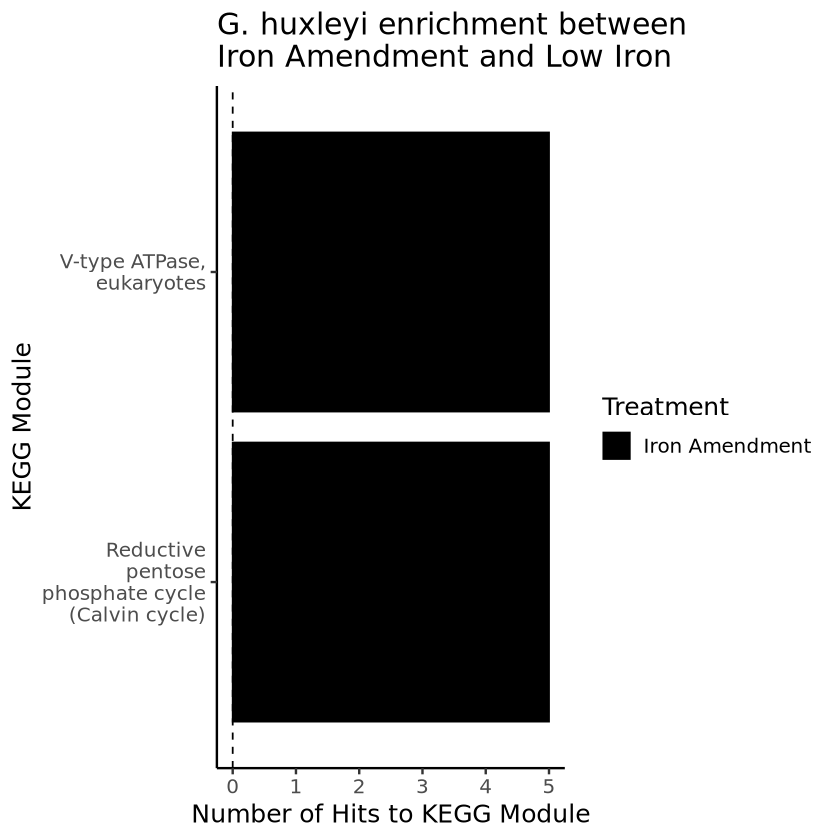

In [11]:
hvl13_de = read.csv('./de_res_files/HvL13.k.csv')
avh13_de = read.csv('./de_res_files/AvH13.k.csv')
avl13_de = read.csv('./de_res_files/AvL13.k.csv')
uni13 = read.csv('../kegg_names/ko13_ls.csv')

mEnrich(hvl13_de, uni13, 'High Iron', 'Low Iron', 'G. huxleyi')
mEnrich(avl13_de, uni13, 'Iron Amendment', 'High Iron', 'G. huxleyi')
mEnrich(avl13_de, uni13, 'Iron Amendment', 'Low Iron', 'G. huxleyi')

In [ ]:
avl4_de = read.csv('./de_res_files/AvL4.k.csv')
uni4 = read.csv('../kegg_names/ko4_ls.csv')

avl4_de$ko_id = avl4_de$row
    ## create a universe which has all ko's from the comparison
    uni4 = unique(uni4$ko_id)
    #pull out significantly difference up regulated genes (high iron treatment)
    up = subset(avl4_de, log2FoldChange > 0 & padj < 0.01)
    #pull out significantly differentially down regulated genes (low iron treatment)
    down = subset(avl4_de, log2FoldChange < 0 & padj < 0.01)

    up_out = enrichKEGG(up$ko_id, pvalueCutoff = 0.05, organism='ko', pAdjustMethod = 'fdr', keyType='kegg', universe=uni4)
up_res=up_out@result
fin_up=filter(up_res, p.adjust<0.05)
 fin_up = fin_high %>% mutate(Treatment = 'Iron Amendment')
    
    down_out = enrichKEGG(down$ko_id, pvalueCutoff = 0.05, organism='ko', pAdjustMethod = 'fdr', keyType='kegg', universe=uni4)
    down_res = down_out@result
    fin_down = filter(down_res, p.adjust<0.05)
    fin_down = fin_down %>% mutate(Treatment="Low Iron")
    
    enrich_full = rbind(fin_up, fin_down)
    
   p= ggplot(enrich_full, aes(Count, reorder(Description,-Count), fill=Treatment)) +
    geom_bar(stat='identity', width=0.9,position=position_dodge(), color='black')+
    theme_classic(base_size=15)+ ylab('KEGG Module') +
    #ggtitle(paste(org, " enrichment between\n",uTreat," and ", dTreat, sep='')) +
    geom_vline(xintercept = 0, linetype='dashed') +
    scale_fill_manual(values=c('black','white'), breaks=c('Iron Amendment', 'Low Iron')) +
    scale_y_discrete(labels=function(x) str_wrap(x,15))+
    xlab('Number of Hits to KEGG Module') 
                     p
                     

#mEnrich(avl4_de, uni4, 'Iron Amendment', 'Low Iron', 'C. closterium 4')

Reading KEGG annotation online: "https://rest.kegg.jp/link/ko/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/ko"...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (5.71% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



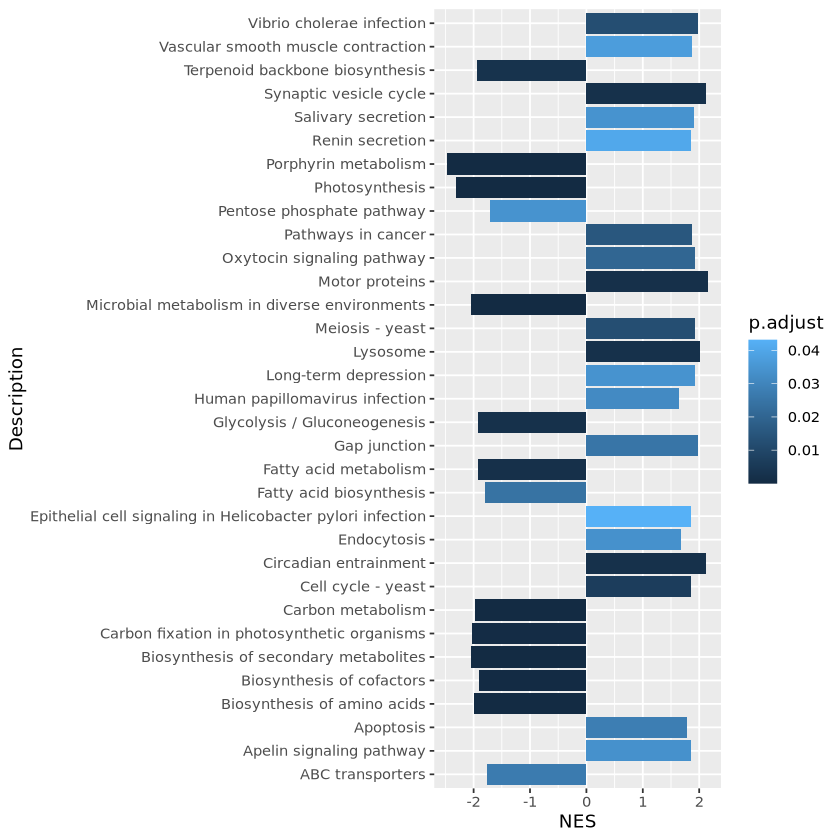

In [4]:
down=HvL8.geneList[(HvL8.geneList<=0)]
up=HvL8.geneList[(HvL8.geneList>=0)]
up=gseKEGG(geneList = HvL8.geneList,organism = 'ko',pvalueCutoff = 0.05) 
new=arrange(up@result, NES)

ggplot(new, aes(NES, Description, fill=p.adjust))+geom_bar(stat='identity')

# Pull our Kegg Metabolism and cell cycle pathways
This will only compare ko's to those which are annotated to metabolism and cell cycle pathways and not human diseases. 

In [10]:
kg.ko=kegg.gsets(species='ko', check.new=T) 
kegg.sigmet=kg.ko$kg.sets[kg.ko$sigmet.idx]
kegg.sigmet.term2gene = data.frame(
    TERM=str_remove(rep(names(kegg.sigmet), sapply(kegg.sigmet, length)), 'ko[[:digit:]]{5}'), 
    GENE= unlist(kegg.sigmet))

kegg.met = kg.ko$kg.sets[kg.ko$met.idx]
kegg.gs.term2gene = data.frame(
    TERM=str_remove(rep(names(kegg.met), sapply(kegg.met, length)), 'ko[[:digit:]]{5}'), 
    GENE= unlist(kegg.met))
head(kegg.gs.term2gene)

,TERM,GENE
,<chr>,<chr>
ko00010 Glycolysis / Gluconeogenesis1,Glycolysis / Gluconeogenesis,K00001
ko00010 Glycolysis / Gluconeogenesis2,Glycolysis / Gluconeogenesis,K00002
ko00010 Glycolysis / Gluconeogenesis3,Glycolysis / Gluconeogenesis,K00016
ko00010 Glycolysis / Gluconeogenesis4,Glycolysis / Gluconeogenesis,K00114
ko00010 Glycolysis / Gluconeogenesis5,Glycolysis / Gluconeogenesis,K00121
ko00010 Glycolysis / Gluconeogenesis6,Glycolysis / Gluconeogenesis,K00128


In [69]:
a=kegg.met[1]
a=data.frame(ko_id=unlist(a))
#a= a %>% rownames_to_column('Path_name') 
head(a)
#a$pat=str_split(a$Path_name, 'ko[[:digit:]]*', simplify = T)
b = str_split_fixed(rownames(a), ' ',n = 2)
b = as_tibble(b, .name_repair = make.names)
colnames(b) = c('path_code','path_name')
c=bind_cols(ko_id=a$ko_id, b)
head(c)


,ko_id
,<chr>
ko00010 Glycolysis / Gluconeogenesis1,K00001
ko00010 Glycolysis / Gluconeogenesis2,K00002
ko00010 Glycolysis / Gluconeogenesis3,K00016
ko00010 Glycolysis / Gluconeogenesis4,K00114
ko00010 Glycolysis / Gluconeogenesis5,K00121
ko00010 Glycolysis / Gluconeogenesis6,K00128


ko_id,path_code,path_name
<chr>,<chr>,<chr>
K00001,ko00010,Glycolysis / Gluconeogenesis1
K00002,ko00010,Glycolysis / Gluconeogenesis2
K00016,ko00010,Glycolysis / Gluconeogenesis3
K00114,ko00010,Glycolysis / Gluconeogenesis4
K00121,ko00010,Glycolysis / Gluconeogenesis5
K00128,ko00010,Glycolysis / Gluconeogenesis6


Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/"...



ko,name
<chr>,<chr>
ko00010,NA


# Run over expression analysis OEA

In [13]:
get.genes_DEG = function(df){
    df = read.csv(paste("./de_res_files/",df,".csv",sep=''))
    colnames(df)[1] = 'ko_id'
    #pull out DE genes
    df=filter(df, padj <0.05) #& abs(log2FoldChange)>1)
    # create a ranked gene list
    df = mutate(df, ranking=sign(log2FoldChange)*-log10(padj))
    ranking=(df$ranking)
    names(ranking)=as.character(df$ko_id)
    geneList=sort(ranking, decreasing=T)
    genes=names(geneList)
}


run.enricher = function(df, direction){
    df = read.csv(paste("./de_res_files/",df,".csv",sep=''))
    colnames(df)[1] = 'ko_id'
    
    if (direction =='up'){
        df=filter(df, log2FoldChange>1 & padj <0.05)
       
        df = mutate(df, ranking=sign(log2FoldChange)*-log10(padj))
        ranking=(df$ranking)
        names(ranking)=as.character(df$ko_id)
        geneList=sort(ranking, decreasing=T)
        genes_DEG=names(geneList)}
    else{
        df=filter(df, log2FoldChange<-1 & padj <0.05)
        
        df = mutate(df, ranking=sign(log2FoldChange)*-log10(padj))
        ranking=(df$ranking)
        names(ranking)=as.character(df$ko_id)
        geneList=sort(ranking, decreasing=T)
        genes_DEG=names(geneList)}
    ore = enricher(genes_DEG, 
                   pvalueCutoff=0.05, 
                   pAdjustMethod = 'fdr',
                   qvalueCutoff=1, 
                   universe=names(geneList),
                   minGSSize=5,
                   TERM2GENE= kegg.gs.term2gene)
    ore
}


plot.ore = function(ORE_df, direction, org, filename){
    ore.title = paste(direction, org,'Pathway Over Expression',sep='\n')
    ORE_dotplot = dotplot(ORE_df, showCategory=30) +  
                    ggtitle(ore.title)
    print(ORE_dotplot)
    ORE_upset = upsetplot(ORE_df)+ggtitle(ore.title)
    #ggsave(filename = paste('../figs/',filename,'_ore_upset.png',sep=''),
    #       plot = ORE_upset,device = 'png',width = 10,height=10)
   
    }


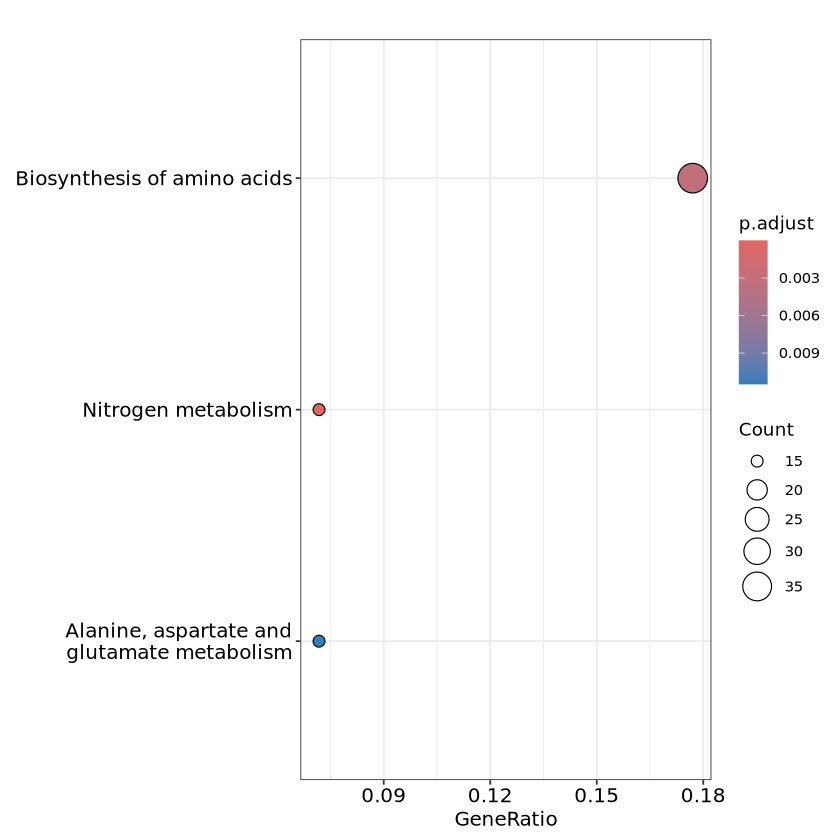

In [30]:
uni13 = read.csv('../kegg_names/ko8_ls.csv')

ore = enricher(names(AvL8.geneList), 
                   pvalueCutoff=0.05, 
                   pAdjustMethod = 'fdr',
                   qvalueCutoff=1, 
                   universe=uni8$ko_id,
                   minGSSize=5,
                   TERM2GENE= kegg.gs.term2gene)
 dotplot(ore, showCategory=30)

In [75]:
head(ore.HvL8@result)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Biosynthesis of secondary metabolites,Biosynthesis of secondary metabolites,Biosynthesis of secondary metabolites,93/152,292/742,8.461548e-10,7.023085e-08,6.502032e-08,K00002/K04123/K09587/K09588/K09589/K09590/K09843/K12637/K12638/K12639/K12640/K20667/K00547/K01081/K12447/K11751/K22395/K01601/K03841/K11819/K19007/K00001/K13830/K10251/K01652/K13517/K01834/K00022/K01770/K01733/K01810/K00794/K09839/K00940/K00991/K02291/K00793/K07515/K00872/K00817/K03428/K01609/K00815/K01807/K00318/K00382/K21480/K13606/K01885/K15404/K02551/K01637/K02078/K00919/K19269/K00106/K00163/K03527/K00655/K06443/K03783/K00645/K19073/K00766/K00958/K00099/K02492/K02293/K01792/K01624/K01638/K11262/K00231/K10206/K00218/K13789/K01803/K00228/K04040/K09838/K03526/K00134/K00053/K01662/K00615/K00927/K03403/K01698/K01599/K01749/K01845/K03404/K10960,93
Porphyrin metabolism,Porphyrin metabolism,Porphyrin metabolism,17/152,28/742,2.377752e-06,7.388692e-05,6.840513e-05,K03428/K21480/K13606/K01885/K19073/K02492/K00231/K00218/K00228/K04040/K03403/K01698/K01599/K01749/K01845/K03404/K10960,17
Brassinosteroid biosynthesis,Brassinosteroid biosynthesis,Brassinosteroid biosynthesis,8/152,8/742,2.670611e-06,7.388692e-05,6.840513e-05,K09587/K09588/K09589/K09590/K12637/K12638/K12639/K12640,8
Carbon fixation in photosynthetic organisms,Carbon fixation in photosynthetic organisms,Carbon fixation in photosynthetic organisms,11/152,19/742,3.167039e-04,6.571606e-03,6.084049e-03,K01601/K03841/K00814/K01100/K00855/K01807/K01624/K01803/K00134/K00615/K00927,11
Carotenoid biosynthesis,Carotenoid biosynthesis,Carotenoid biosynthesis,6/152,7/742,3.964741e-04,6.581471e-03,6.093182e-03,K09843/K09839/K02291/K06443/K02293/K09838,6
Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,12/152,28/742,5.183955e-03,7.171138e-02,6.639100e-02,K00002/K03841/K00001/K01834/K01810/K00382/K00163/K01792/K01624/K01803/K00134/K00927,12


In [14]:
HvL8_de=get.genes_DEG('HvL8.k')
AvL8_de=get.genes_DEG('AvL8.k')
AvH8_de=get.genes_DEG('AvH8.k')
ore.HvL8.u=run.enricher('HvL8.k','up')
ore.AvL8.u=run.enricher('AvL8.k','up')
ore.AvH8.u=run.enricher('AvH8.k','up')
ore.HvL8.d=run.enricher('HvL8.k','down')
ore.AvL8.d=run.enricher('AvL8.k','down')
ore.AvH8.d=run.enricher('AvH8.k','down')

HvL6_de=get.genes_DEG('HvL6.k')
AvL6_de=get.genes_DEG('AvL6.k')
AvH6_de=get.genes_DEG('AvH6.k')
ore.HvL6.u=run.enricher('HvL6.k','up')
ore.AvL6.u=run.enricher('AvL6.k','up')
ore.AvH6.u=run.enricher('AvH6.k','up')
ore.HvL6.d=run.enricher('HvL6.k','down')
ore.AvL6.d=run.enricher('AvL6.k','down')
ore.AvH6.d=run.enricher('AvH6.k','down')

HvL13_de=get.genes_DEG('HvL13.k')
AvL13_de=get.genes_DEG('AvL13.k')
AvH13_de=get.genes_DEG('AvH13.k')
ore.HvL13.u=run.enricher('HvL13.k','up')
ore.AvL13.u=run.enricher('AvL13.k','up')
ore.AvH13.u=run.enricher('AvH13.k','up')
ore.HvL13.d=run.enricher('HvL13.k','down')
ore.AvL13.d=run.enricher('AvL13.k','down')
ore.AvH13.d=run.enricher('AvH13.k','down')


AvL4_de=get.genes_DEG('AvL4.k')
ore.AvL4.u=run.enricher('AvL4.k','up')
ore.AvL4.d=run.enricher('AvL4.k','down')
ore.AvL6.u

No gene sets have size between 5 and 500 ...

--> return NULL...



#
# over-representation test
#
#...@organism 	 UNKNOWN 
#...@ontology 	 UNKNOWN 
#...@gene 	 chr [1:321] "K02997" "K02639" "K10534" "K00940" "K08917" "K02910" "K17433" ...
#...pvalues adjusted by 'fdr' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


In [15]:
Avl8=mutate(ore.AvL8@result, organism='C. closterium 8')
Avl4=mutate(ore.AvL4@result, organism='C. closterium 4')
Avl6=mutate(ore.AvL6@result, organism='G. oceanica')
Avl13=mutate(ore.AvL13@result, organism='E. huxleyi')

Avh8=mutate(ore.AvH8@result, organism='C. closterium 8')
Avh6=mutate(ore.AvH6@result, organism='G. oceanica')
Avh13=mutate(ore.AvH13@result, organism='E. huxleyi')

Hvl8=mutate(ore.HvL8@result, organism='C. closterium 8')
Hvl6=mutate(ore.HvL6@result, organism='G. oceanica')
Hvl13=mutate(ore.HvL13@result, organism='E. huxleyi')

Hvl = bind_rows(Hvl13,Hvl8,Hvl6)
Avl = bind_rows(Avl4, Avl13, Avl8, Avl6)
Avh = bind_rows(Avh13, Avh8, Avh6)

plot.all.bar = function(df, reg.up.down, comparison){
       df$direction=ifelse(df$NES > 0, 'up','down')
       
    regulation=reg.up.down
    names(regulation)=c('up','down')
    
    up=ggplot(filter(df,direction=='up'), aes(abs(NES), Description, fill=p.adjust))+
        scale_fill_gradient(low = 'red',high = 'blue')+
        geom_bar(stat = 'identity') + 
    facet_wrap(~organism)+
        ylab(element_blank()) + 
    xlab('Normalized enrichment score')+
    theme_dose()
    
    down=ggplot(df, aes(abs(NES), fct_reorder(Description, NES), fill=p.adjust))+
        scale_fill_gradient(low = 'red',high = 'blue')+
        geom_bar(stat = 'identity') + 
        facet_grid(direction~organism, labeller=labeller(direction=regulation), scales='free',)+
        scale_y_discrete(labels=function(x) str_wrap(x, 40)) +
        ylab(element_blank()) + 
        xlab('Normalized enrichment score')+
                         theme_bw() +
        theme(text = element_text(size=40, color='black'),strip.text=element_text(size=40), legend.key.size=unit(4,'cm'))

   # ggsave(filename = paste('../figs/',comparison,'_enrich_bar.png', sep=''), plot = down, device = 'png', width = 30, height = 30)
    down
}

ERROR: Error in eval(expr, envir, enclos): object 'ore.AvL8' not found


Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


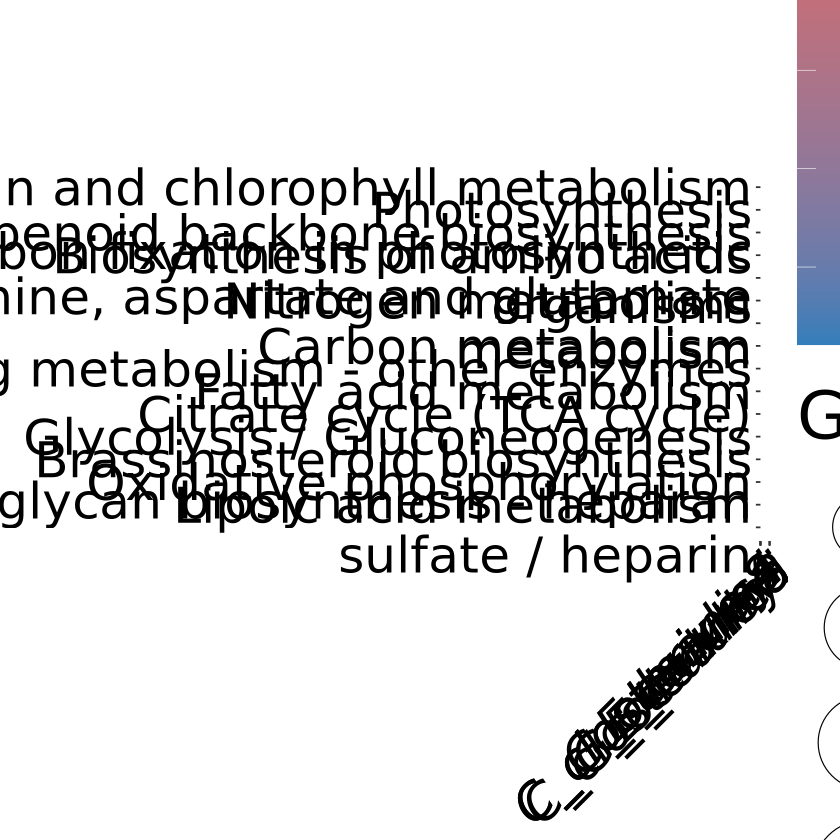

In [16]:
HvL8_de=data.frame(Gene=get.genes_DEG('HvL8.k'), 'organism'='C_closterium8', 'treatment'='High_Fe')
AvL8_de=data.frame(Gene=get.genes_DEG('AvL8.k'), 'organism'='C_closterium8', 'treatment'='Fe_ammendment')
HvL6_de=data.frame(Gene=get.genes_DEG('HvL6.k'), 'organism'='G_oceanica', 'treatment'='High_Fe')
AvL6_de=data.frame(Gene=get.genes_DEG('AvL6.k'), 'organism'='G_oceanica', 'treatment'='Fe_ammendment')
HvL13_de=data.frame(Gene=get.genes_DEG('HvL13.k'), 'organism'='E_huxleyi', 'treatment'='High_Fe')
AvL13_de=data.frame(Gene=get.genes_DEG('AvL13.k'), 'organism'='E_huxleyi', 'treatment'='Fe_ammendment')
AvL4_de=data.frame(Gene=get.genes_DEG('AvL4.k'), 'organism'='C_closterium4', 'treatment'='Fe_ammendment')
org_comp = bind_rows(HvL8_de, AvL8_de, AvL4_de, HvL6_de, AvL6_de, HvL13_de, AvL13_de)

xx = compareCluster(Gene~organism+treatment, data=org_comp, fun=enricher, TERM2GENE=kegg.gs.term2gene, minGSSize=5)

dotplot_comp =function(df){
    dotplot(df, x='organism') + scale_size(range=c(10,30))+
                facet_grid(~treatment, scales='free')+
                xlab(NULL) + 
                scale_y_discrete(labels=function(x) str_wrap(x, 40)) +
                scale_color_gradientn(colours=c("#b3eebe", "#46bac2", "#371ea3"),
                    guide=guide_colorbar(reverse=TRUE, order=1)) +
                guides(size = guide_legend(override.aes=list(shape=1))) +
                theme(text = element_text(color='black', size=40),
                      panel.grid.major.y = element_line(linetype='dotted', color='#808080'),
                      panel.grid.major.x = element_blank(),
                      strip.text=element_text(size=40),
                      axis.text.y=element_text(size=30, color='black'),
                    axis.text.x = element_text(size=30,angle = 45, vjust = 1, hjust=1, face = 'italic'),
                     legend.key.size=unit(2,'cm'))
                     }
dotplotxx=dotplot_comp(xx)
ggsave(filename = '../figs/all.dotplot.enricher.png', plot = dotplotxx, device = 'png', width = 30, height = 20)
                                 dotplotxx

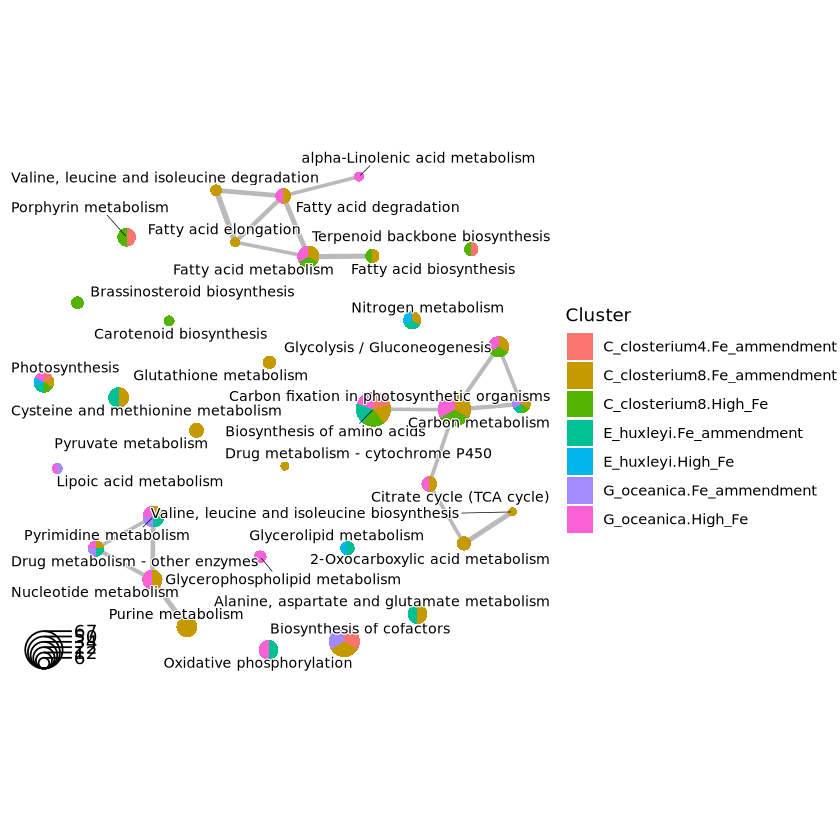

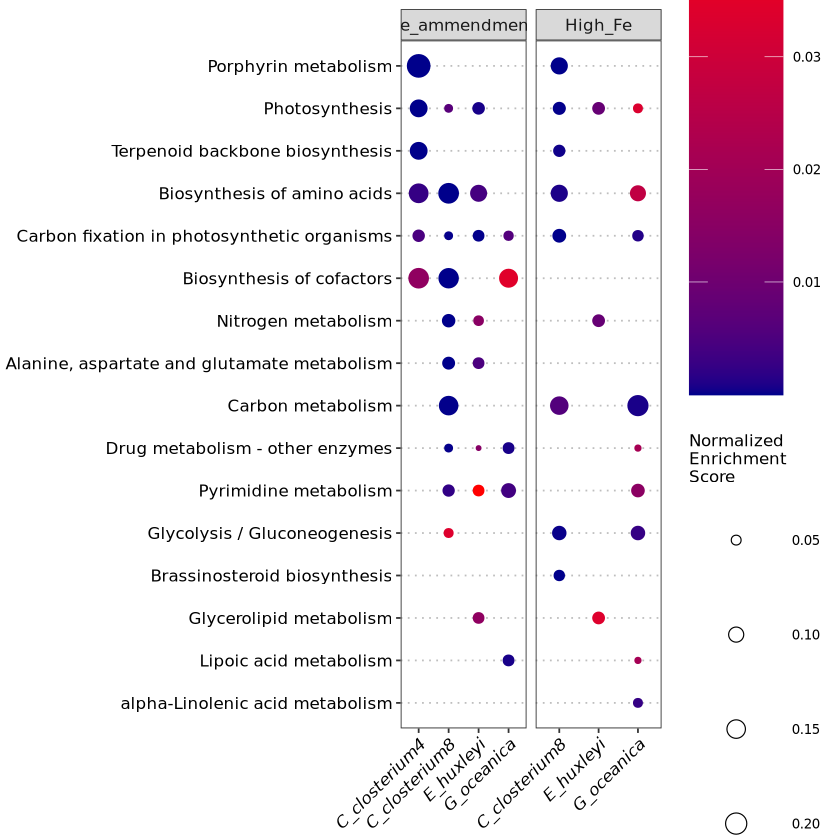

In [238]:
x=pairwise_termsim(xx)
emapplot(x)

ggplot(xx, aes(organism, Description, color=p.adjust, size=GeneRatio))+ 
    geom_count(stat = 'identity')+
    #scale_size(range=c(5,20))+
    facet_grid(~treatment, scales='free')+
    xlab(NULL) + 
    ylab(NULL) +
    #scale_y_discrete(labels=function(x) str_wrap(x, 40)) +
                     scale_color_gradient(low = 'darkblue', high='red')+
                     guides(size = guide_legend(title = 'Normalized\nEnrichment\nScore',
                                                override.aes=list(shape=1))) +
                     theme_dose()+
                     theme(text = element_text(color='black', size=10),
                           panel.grid.major.y = element_line(linetype='dotted', color='grey'),
                           panel.grid.major.x = element_blank(),
                           strip.text=element_text(size=10),
                           axis.text.y=element_text(size=10, color='black'),
                           axis.text.x = element_text(size=10,angle = 45, vjust = 1, hjust=1, face = 'italic'),
                           legend.key.size=unit(2,'cm'))

In [247]:
x@compareClusterResult$Description

[1] " Porphyrin metabolism"                       
 [2] " Photosynthesis"                             
 [3] " Terpenoid backbone biosynthesis"            
 [4] " Biosynthesis of amino acids"                
 [5] " Carbon fixation in photosynthetic organisms"
 [6] " Biosynthesis of cofactors"                  
 [7] " Biosynthesis of amino acids"                
 [8] " Nitrogen metabolism"                        
 [9] " Biosynthesis of cofactors"                  
[10] " Alanine, aspartate and glutamate metabolism"
[11] " Carbon metabolism"                          
[12] " Drug metabolism - other enzymes"            
[13] " Nucleotide metabolism"                      
[14] " Purine metabolism"                          
[15] " Carbon fixation in photosynthetic organisms"
[16] " Fatty acid metabolism"                      
[17] " Glutathione metabolism"                     
[18] " Cysteine and methionine metabolism"         
[19] " Pyrimidine metabolism"                      
[20] " Fatty acid elongation"                      
[21] " Photosynthesis"                             
[22] " Citrate cycle (TCA cycle)"                  
[23] " Fatty acid biosynthesis"                    
[24] " Fatty acid degradation"                     
[25] " Valine, leucine and isoleucine biosynthesis"
[26] " 2-Oxocarboxylic acid metabolism"            
[27] " Pyruvate metabolism"                        
[28] " Valine, leucine and isoleucine degradation" 
[29] " Glycolysis / Gluconeogenesis"               
[30] " Drug metabolism - cytochrome P450"          
[31] " Brassinosteroid biosynthesis"               
[32] " Carbon fixation in photosynthetic organisms"
[33] " Porphyrin metabolism"                       
[34] " Photosynthesis"                             
[35] " Glycolysis / Gluconeogenesis"               
[36] " Terpenoid backbone biosynthesis"            
[37] " Fatty acid metabolism"                      
[38] " Biosynthesis of amino acids"                
[39] " Fatty acid biosynthesis"                    
[40] " Carbon metabolism"                          
[41] " Carotenoid biosynthesis"                    
[42] " Carbon fixation in photosynthetic organisms"
[43] " Photosynthesis"                             
[44] " Biosynthesis of amino acids"                
[45] " Alanine, aspartate and glutamate metabolism"
[46] " Drug metabolism - other enzymes"            
[47] " Nitrogen metabolism"                        
[48] " Glycerolipid metabolism"                    
[49] " Oxidative phosphorylation"                  
[50] " Cysteine and methionine metabolism"         
[51] " Pyrimidine metabolism"                      
[52] " Photosynthesis"                             
[53] " Nitrogen metabolism"                        
[54] " Glycerolipid metabolism"                    
[55] " Lipoic acid metabolism"                     
[56] " Drug metabolism - other enzymes"            
[57] " Pyrimidine metabolism"                      
[58] " Carbon fixation in photosynthetic organisms"
[59] " Biosynthesis of cofactors"                  
[60] " Carbon metabolism"                          
[61] " Carbon fixation in photosynthetic organisms"
[62] " alpha-Linolenic acid metabolism"            
[63] " Glycolysis / Gluconeogenesis"               
[64] " Pyrimidine metabolism"                      
[65] " Glycerophospholipid metabolism"             
[66] " Citrate cycle (TCA cycle)"                  
[67] " Nucleotide metabolism"                      
[68] " Lipoic acid metabolism"                     
[69] " Drug metabolism - other enzymes"            
[70] " Biosynthesis of amino acids"                
[71] " Fatty acid metabolism"                      
[72] " Fatty acid degradation"                     
[73] " Photosynthesis"                             
[74] " Oxidative phosphorylation"

# Run GSE analysis 

In [11]:
run.gsea = function(geneList){
    gsea = GSEA(geneList, minGSSize=5, eps = 0,
                pvalueCutoff = 0.05, 
                pAdjustMethod = 'fdr',
                TERM2GENE = kegg.gs.term2gene)
    gsea    
}              

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple

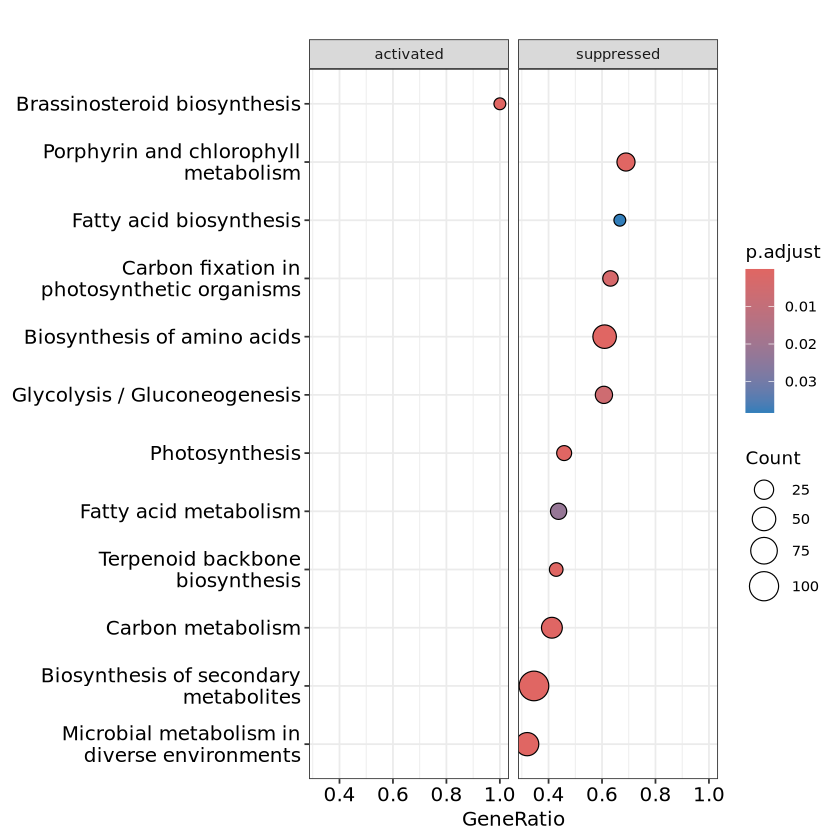

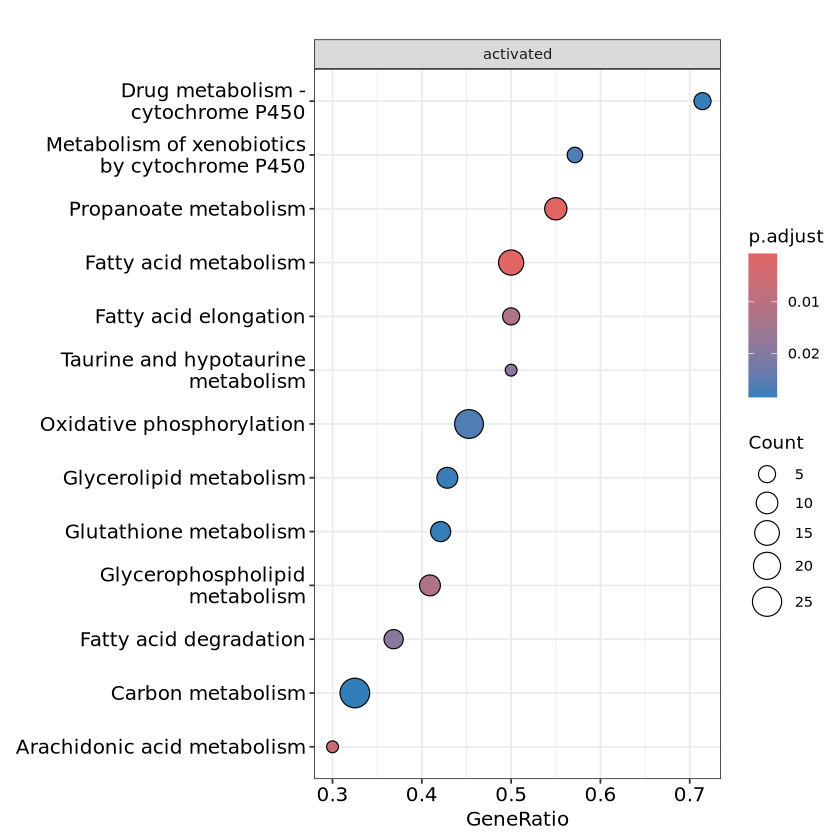

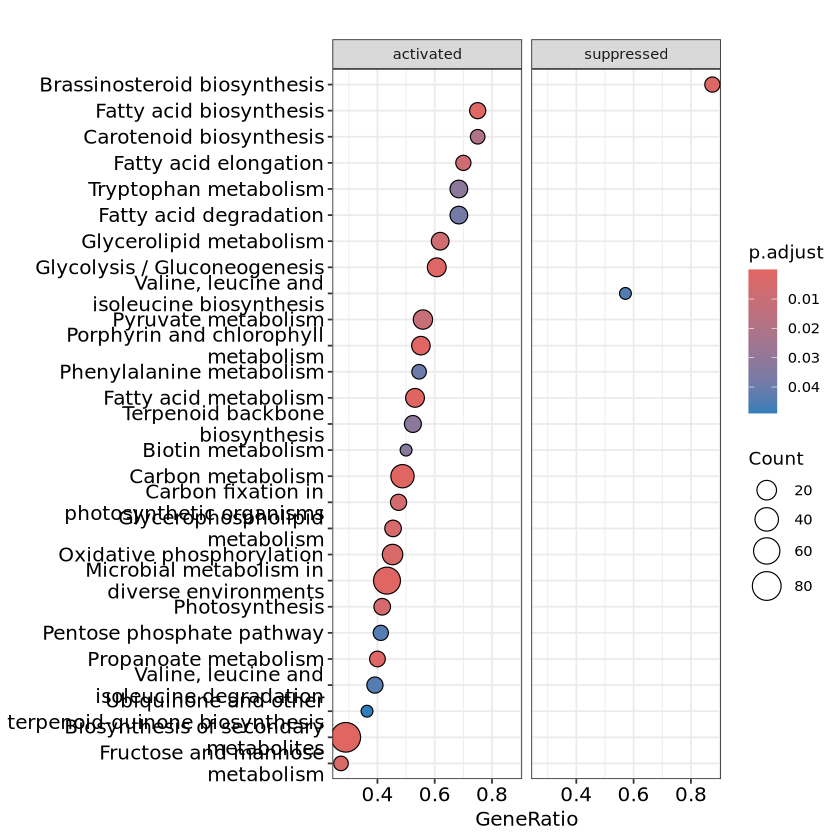

In [12]:
gsea.HvL8=run.gsea(HvL8.geneList)
gsea.AvL8=run.gsea(AvL8.geneList)
gsea.AvH8=run.gsea(AvH8.geneList)

dotplot(gsea.HvL8, showCategory=100,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL8, showCategory=100,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvH8, showCategory=100,split=".sign") + 
                    facet_grid(.~.sign)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



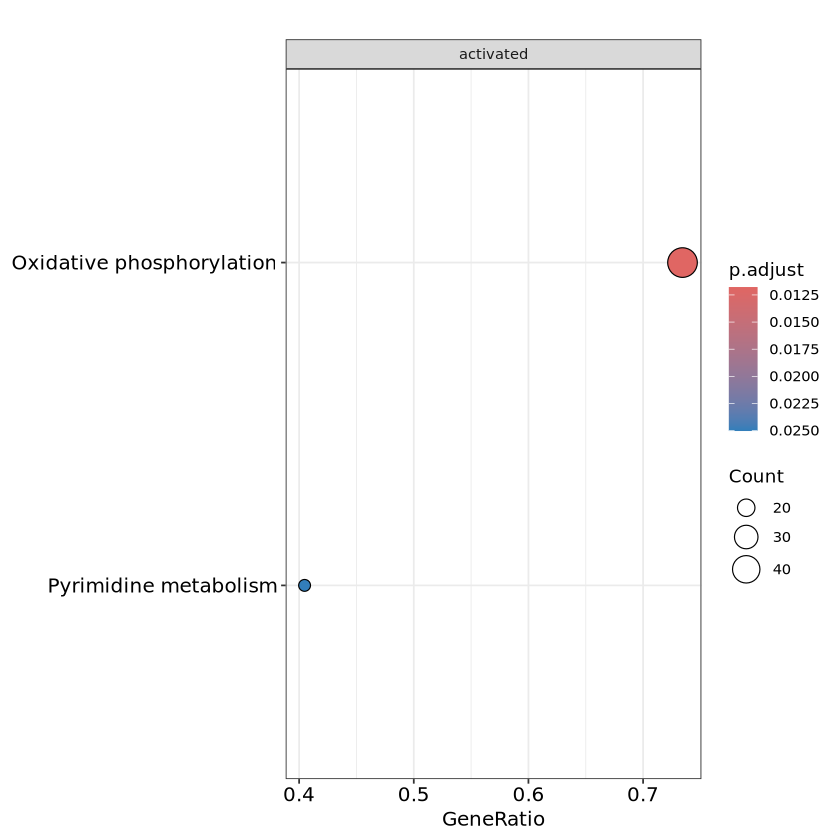

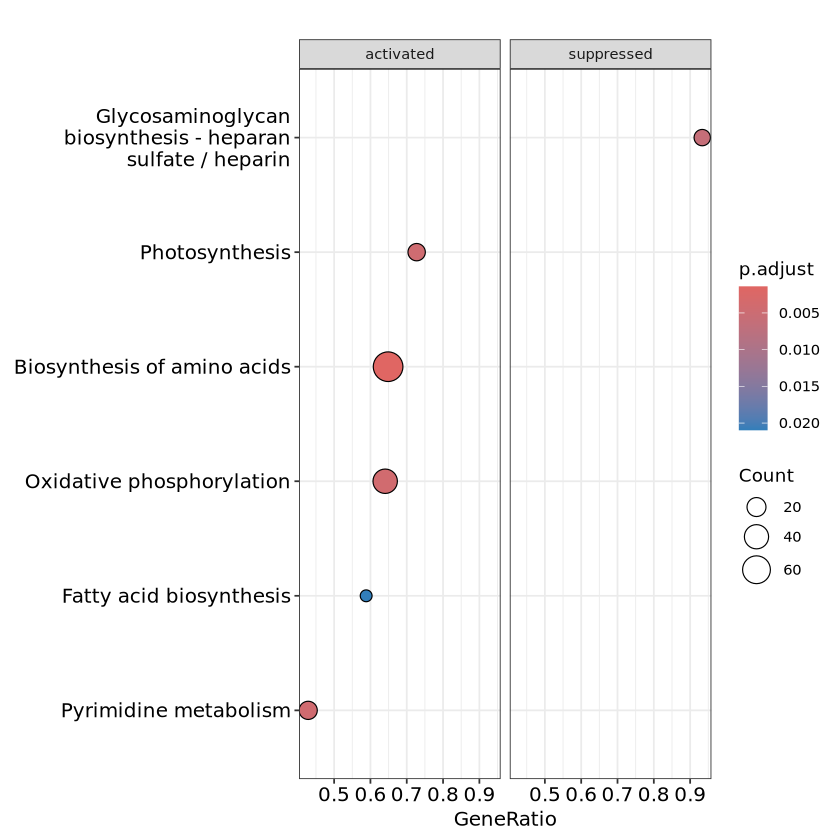

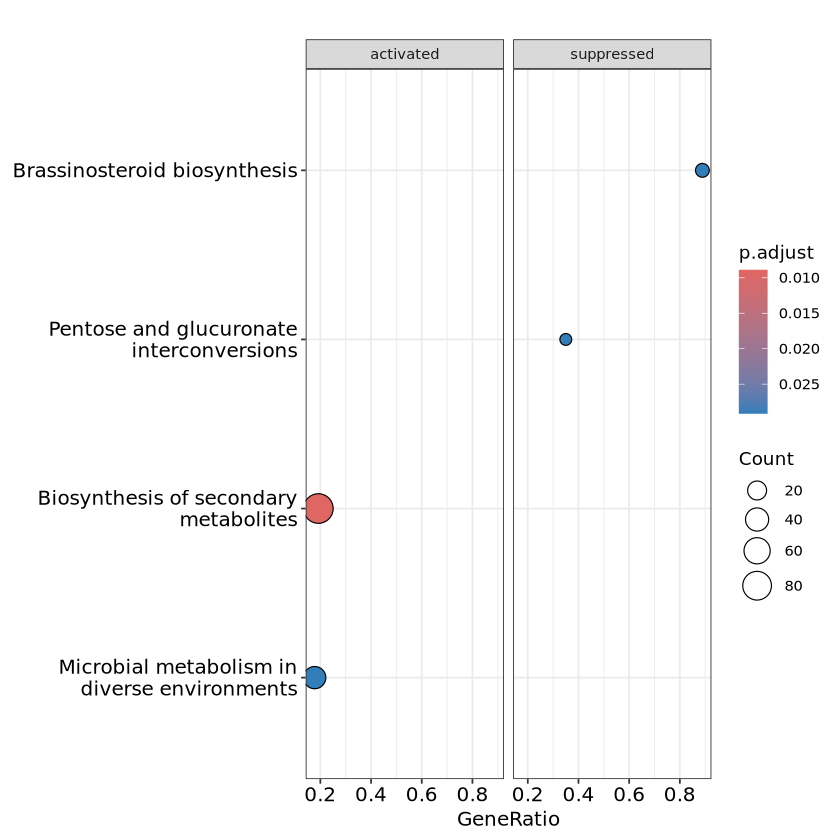

In [13]:
gsea.HvL6=run.gsea(HvL6.geneList)
gsea.AvL6=run.gsea(AvL6.geneList)
gsea.AvH6=run.gsea(AvH6.geneList)

dotplot(gsea.HvL6, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL6, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvH6, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (5.91% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



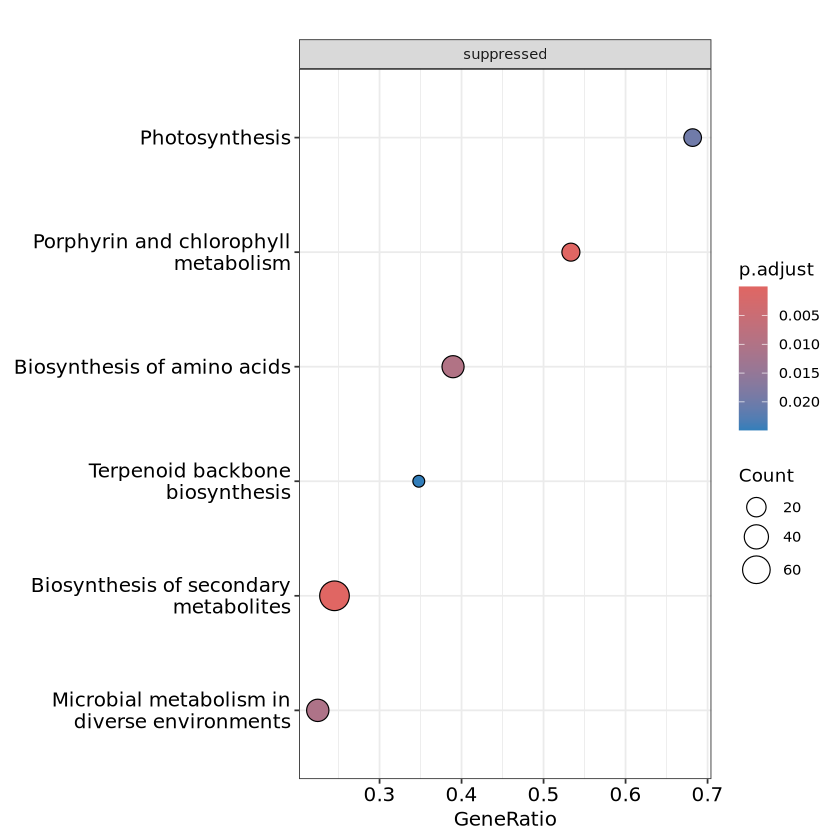

In [14]:

gsea.AvL4=run.gsea(AvL4.geneList)
dotplot(gsea.AvL4, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.69% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.69% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.69% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



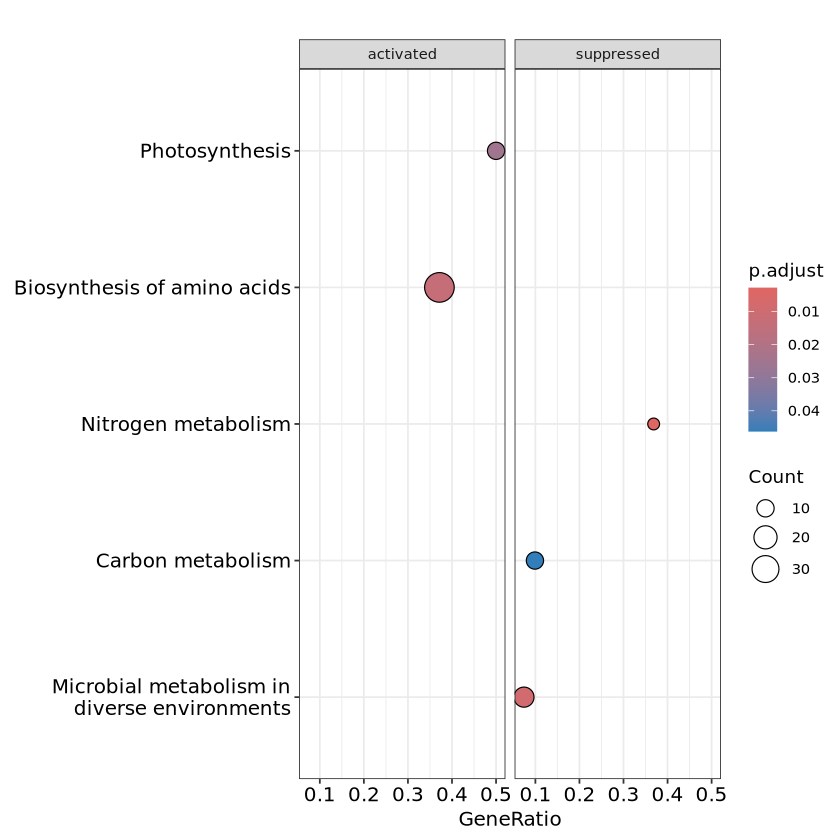

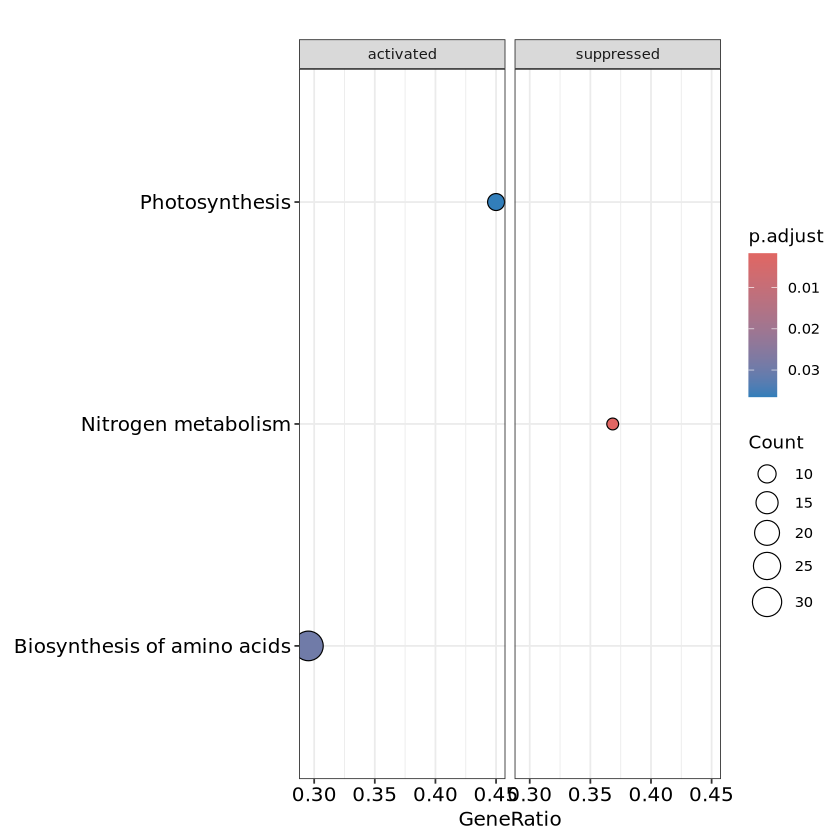

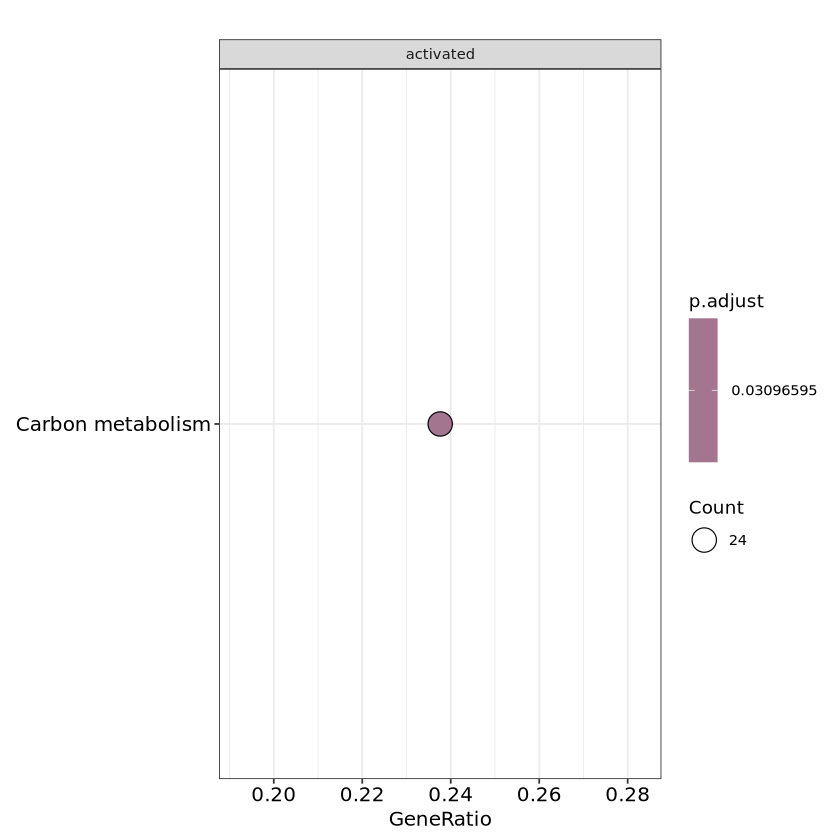

In [15]:
gsea.HvL13=run.gsea(HvL13.geneList)
gsea.AvL13=run.gsea(AvL13.geneList)
gsea.AvH13=run.gsea(AvH13.geneList)

dotplot(gsea.HvL13, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvL13, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)
dotplot(gsea.AvH13, showCategory=30,split=".sign") + 
                    facet_grid(.~.sign)

## Pull out result DF and add organism name
Create a df for each comparison 

In [16]:
Avl8=mutate(gsea.AvL8@result, organism='C. closterium UGA8')
Avl4=mutate(gsea.AvL4@result, organism='C. closterium UGA4')
Avl6=mutate(gsea.AvL6@result, organism='G. oceanica')
Avl13=mutate(gsea.AvL13@result, organism='G. huxleyi')

Avh8=mutate(gsea.AvH8@result, organism='C. closterium UGA8')
Avh6=mutate(gsea.AvH6@result, organism='G. oceanica')
Avh13=mutate(gsea.AvH13@result, organism='G. huxleyi')

Hvl8=mutate(gsea.HvL8@result, organism='C. closterium UGA8')
Hvl6=mutate(gsea.HvL6@result, organism='G. oceanica')
Hvl13=mutate(gsea.HvL13@result, organism='G. huxleyi')

Hvl = bind_rows(Hvl13,Hvl8,Hvl6)
Avl = bind_rows(Avl4, Avl13, Avl8, Avl6)
Avh = bind_rows(Avh13, Avh8, Avh6)


## Plot enrichments

In [31]:
plot.all.bar = function(df, reg.up.down, comparison){
    df$direction=ifelse(df$NES > 0, 'up','down')
       
    regulation=reg.up.down
    names(regulation)=c('up','down')
    
    up=ggplot(filter(df,direction=='up'), aes(abs(NES), Description, fill=p.adjust))+
        scale_fill_gradient(low = 'red',high = 'blue')+
        geom_bar(stat = 'identity') + 
    facet_wrap(~organism)+
        ylab(element_blank()) + 
    xlab('Normalized enrichment score')+
    theme_dose()
    
    down=ggplot(df, aes(abs(NES), fct_reorder(Description, NES), fill=p.adjust))+
        scale_fill_gradient(guide = 'Normalized Enrichment Score', low = 'red',high = 'blue')+
        geom_bar(stat = 'identity') + 
        facet_grid(direction~organism, labeller=labeller(direction=regulation), scales='free',)+
        scale_y_discrete(labels=function(x) str_wrap(x, 40)) +
        ylab(element_blank()) + 
        xlab('Normalized enrichment score')+
                         theme_bw() +
        theme(text = element_text(size=40, color='black'),strip.text=element_text(size=40, face='bold'), strip.background = 'white', 
              legend.key.size=unit(4,'cm'))

    ggsave(filename = paste('../figs/',comparison,'_enrich_bar.png', sep=''), plot = down, device = 'png', width = 30, height = 30)
    down
}
unique(Avl$ID)

[1] " Biosynthesis of secondary metabolites"                     
 [2] " Porphyrin and chlorophyll metabolism"                      
 [3] " Photosynthesis"                                            
 [4] " Biosynthesis of amino acids"                               
 [5] " Microbial metabolism in diverse environments"              
 [6] " Glycosaminoglycan biosynthesis - heparan sulfate / heparin"
 [7] " Terpenoid backbone biosynthesis"                           
 [8] " Nitrogen metabolism"                                       
 [9] " Propanoate metabolism"                                     
[10] " Glycerophospholipid metabolism"                            
[11] " Arachidonic acid metabolism"                               
[12] " Fatty acid metabolism"                                     
[13] " Taurine and hypotaurine metabolism"                        
[14] " Pyrimidine metabolism"                                     
[15] " Oxidative phosphorylation"                                 
[16] " Fatty acid biosynthesis"

## Make dot plots
First, make treatment column and filter enrichment by positive/negative NES
Make dotplot with organisms on X and Description on Y. 

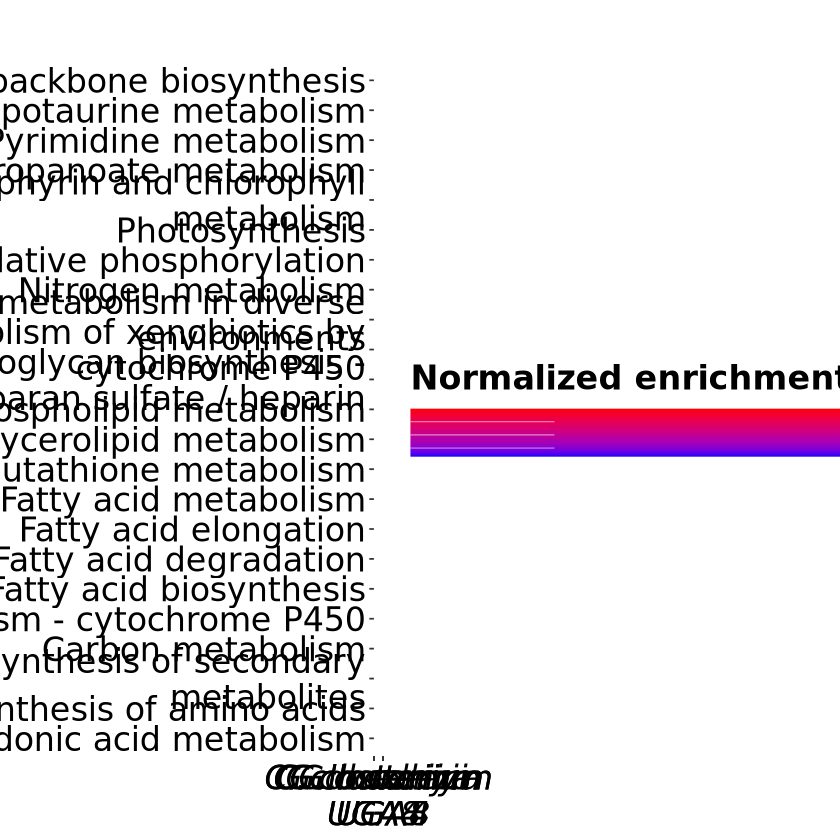

In [17]:
Hvl$treatment = ifelse(Hvl$NES > 0, 'High Iron','Low Iron')
Avl$treatment = ifelse(Avl$NES > 0, 'Iron Amendment', 'Low Iron')
Avh$treatment = ifelse(Avh$NES > 0, 'Iron Amendment', 'High Iron')

all.gsea.dotplot = function(df){
    ggplot(df, aes(organism, Description, color=p.adjust, size=abs(NES)))+ 
   geom_point(stat = 'identity', size=20)+
facet_grid(~treatment, scales='free_y')+
theme_bw()+
xlab(NULL) + 
ylab(element_blank()) +
scale_y_discrete(labels=function(x) str_wrap(x, 35))+ #, expand=c(0.02,0.02)) +
scale_x_discrete(labels=function(x) str_wrap(x, 15)) +
scale_color_gradient(low = 'red', high='blue')+
guides(color=guide_colorbar(title = 'Normalized enrichment score', reverse=TRUE, 
                            title.theme = element_text(size=20, face='bold'),
                           title.position='top', label.theme=element_text(size=20),
                           barwidth=30, barheight=2)) +
theme(text = element_text(color='black', size=20), 
          panel.grid.minor = element_line(colour = 'grey'), 
          strip.text=element_text(size=25, face='bold'), 
          strip.background=element_rect(fill='white'), 
          axis.text.y=element_text(size=20, color='black'), 
          axis.text.x = element_text(size=20, face = 'italic', color='black'),
    plot.margin=margin(0.2,0.2,0.2,3, unit='cm'))
}

#png(file = '../figs/gsea_dotplot_HvL.png',width = 10, height = 15)
hvl.gsea.dotplot = all.gsea.dotplot(Hvl)    
#print(hvl.gsea.dotplot)
#dev.off()
#ggsave(filename = '../figs/gsea_dotplot_HvL.png', hvl.gsea.dotplot, device='png', height = 10, width=15)
                 
#png(file = '../figs/gsea_dotplot_AvL.png',width = 10, height = 15)
avl.gsea.dotplot = all.gsea.dotplot(Avl) 
#print(avl.gsea.dotplot)
#dev.off()
#ggsave(filename = '../figs/gsea_dotplot_AvL.png', avl.gsea.dotplot, device='png', height = 5, width=8)
                 
#png(file = '../figs/gsea_dotplot_AvH.png',width = 10, height = 15)
avh.gsea.dotplot = all.gsea.dotplot(Avh)                
#print(avh.gsea.dotplot)
#dev.off()
# ggsave(filename = '../figs/gsea_dotplot_AvH.png', avh.gsea.dotplot, device='png', height = 15, width=15)
                 
avl.gsea.dotplot

In [18]:
                                  
#gsea_dotplot_all= ggarrange(avl.gsea.dotplot, hvl.gsea.dotplot, ncol=1, common.legend=T, align='v', legend='right')      
                 
#ggsave(filename = '../figs/gsea_dotplot_all.png', gsea_dotplot_all, device='png', height = 25, width=19)

gsea_dotplot_all= ggarrange(avl.gsea.dotplot, hvl.gsea.dotplot, ncol=1, common.legend=T, font.label = element_text(size=30, face='bold'),
                            align='v', legend='bottom',labels = c('A','B'))  
                 
ggsave(filename = '../figs/gsea_dotplot_all2.png', gsea_dotplot_all, device='png', height = 25, width=23)

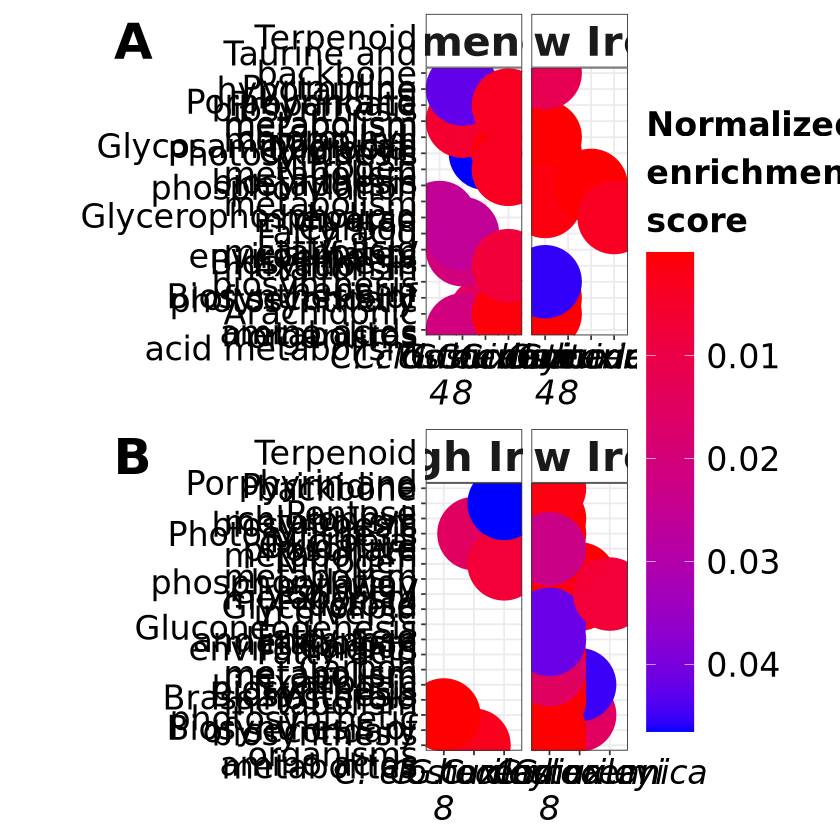

In [17]:
gsea_dotplot_all

# Make table of enrichment and genes within pathways.

In [23]:
colnames(Hvl)
split_into_multiple <- function(column, pattern = "/", into_prefix){
    #adapted from post on stack overflow
    cols <- str_split_fixed(column, pattern, n = Inf)
  # Replace empty matrix indicies with NA's 
    cols[which(cols == "")] <- NA
  # turn matrix into a table with unique but arbitraty column names  
    cols <- as_tibble(cols, .name_repair = make.names)
  # where m = # columns in tibble 'cols'
    m <- dim(cols)[2]
  # assign column names as 'into_prefix_1', 'into_prefix_2', ..., 'into_prefix_m' 
    names(cols) <- paste(into_prefix, 1:m, sep = "_")
    print('# of values in matrix w/o NA:')
    print(sum(!is.na(cols)))
    return(cols)
}

clean_ko <- function(df){
    ko_iterations <- split_into_multiple(df$core_enrichment, "/", "ko:")
    df = df %>% select(c('Description','organism','treatment','NES')) %>% bind_cols(ko_iterations)
    df_clean = pivot_longer(df, cols = !c('Description','organism','treatment','NES'), 
                            values_drop_na = T,
                            values_to = 'ko_id', names_to = 'ko_count')
    df_clean=df_clean %>% select(!'ko_count')
    df_clean
    }

core.ko.Hvl=clean_ko(Hvl)
core.ko.Avl=clean_ko(Avl)
core.ko.Avh=clean_ko(Avh)
head(core.ko.Avl)

[1] "ID"              "Description"     "setSize"         "enrichmentScore"
 [5] "NES"             "pvalue"          "p.adjust"        "qvalue"         
 [9] "rank"            "leading_edge"    "core_enrichment" "organism"       
[13] "treatment"

[1] "# of values in matrix w/o NA:"
[1] 611
[1] "# of values in matrix w/o NA:"
[1] 540
[1] "# of values in matrix w/o NA:"
[1] 740


Description,organism,treatment,NES,ko_id
<chr>,<chr>,<chr>,<dbl>,<chr>
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K01953
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K01490
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K00589
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K00845
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K01687
Biosynthesis of secondary metabolites,C. closterium 4,Low Iron,-1.939732,K09838


In [24]:
ko.def=read.csv('../kegg_names/ko_def.csv')
ko.def$name=str_remove(ko.def$name, '\\[EC:.+')

core.ko.Hvl = right_join(ko.def, core.ko.Hvl, by='ko_id')
core.ko.Avl = right_join(ko.def, core.ko.Avl, by='ko_id')
core.ko.Avh = right_join(ko.def, core.ko.Avh, by='ko_id')


In [25]:
write.csv(core.ko.Hvl,'./de_res_files/core.ko.Hvl.csv',  row.names=F)
write.csv(core.ko.Avl,'./de_res_files/core.ko.Avl.csv',  row.names=F)
write.csv(core.ko.Avh,'./de_res_files/core.ko.Avh.csv',  row.names=F)